# Welcome to the Lab 🥼🧪

## Market Supply & Demand and Rental, Listings and Purchase Price Analysis

Let's review supply, demand and pricing characteristics related to listings, sales and rental prices

Let's get into the lab and take a peak at whats going on.

**Note** This notebook will work with any of the 70k+ markets supported by the Parcl Labs API.

As a reminder, you can get your Parcl Labs API key [here](https://dashboard.parcllabs.com/signup) to follow along. 

To run this immediately, you can use Google Colab. Remember, you must set your `PARCL_LABS_API_KEY` as a secret. See this [guide](https://medium.com/@parthdasawant/how-to-use-secrets-in-google-colab-450c38e3ec75) for more information.

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ParclLabs/parcllabs-examples/blob/main/python/supply_demand.ipynb)

You can expect to create this 👇

![Chart](assets/purchase_price_vs_new_listings_price.png)

In [1]:
# Environment setup
import os
import sys
import subprocess
from datetime import datetime

# Collab setup from one click above
if "google.colab" in sys.modules:
    from google.colab import userdata
    %pip install parcllabs plotly kaleido
    api_key = userdata.get('PARCL_LABS_API_KEY')
else:
    api_key = os.getenv('PARCL_LABS_API_KEY')

In [2]:
import parcllabs
import pandas as pd
import plotly.express as px
from parcllabs import ParclLabsClient

print(f"Parcl Labs Version: {parcllabs.__version__}")

Parcl Labs Version: 0.1.16


In [38]:
# charting setup
# set some constants for the analysis, such as the logo for the chart, we have a white and blue version
labs_logo_lookup = {
    'blue': 'https://parcllabs-assets.s3.amazonaws.com/powered-by-parcllabs-api.png',
    'white': 'https://parcllabs-assets.s3.amazonaws.com/powered-by-parcllabs-api-logo-white+(1).svg'
}

# set charting constants
labs_logo_dict = dict(
        source=labs_logo_lookup['white'],
        xref="paper",
        yref="paper",
        x=0.5,  # Centering the logo below the title
        y=1.02,  # Adjust this value to position the logo just below the title
        sizex=0.15, 
        sizey=0.15,
        xanchor="center",
        yanchor="bottom"
)

# define image dimentions
media_img_size_lookup = {
    'X': {
        'width': 1600,
        'height': 900
    }
}

# optimize the visual for the platform in this case X
PLATFORM = 'X'

# set image sizes
IMG_WIDTH = media_img_size_lookup[PLATFORM]['width']
IMG_HEIGHT = media_img_size_lookup[PLATFORM]['height']

# plotting title settings
PLOT_TITLE_SETTINGS = {
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }

In [39]:
client = ParclLabsClient(api_key=api_key)

In [40]:
# we are looking at homes in San Diego, so we look for the name and the type of market
results = client.search_markets.retrieve(
    query='Atlanta',
    location_type='CBSA',
    as_dataframe=True
)

results.head()

,parcl_id,country,geoid,state_fips_code,name,state_abbreviation,region,location_type,total_population,median_income,parcl_exchange_market,pricefeed_market,case_shiller_10_market,case_shiller_20_market
0,2887280,USA,12060,None,"Atlanta-Sandy Springs-Alpharetta, Ga",None,None,CBSA,6094752,82625,0,1,0,1


In [41]:
# we see that the the first result is the city of San Diego, so we will use the parcl id of 5374167
analysis_parcl_id = results.iloc[0]['parcl_id']
name = results.iloc[0]['name']

# set default save directory
save_dir = './graphics'
new_dir_name = f"{analysis_parcl_id}-{name}-{datetime.today().date()}"
output_dir = os.path.join(save_dir, new_dir_name)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print(f"In this analysis, we are studying: {name} which has parcl id: {analysis_parcl_id}. Saving graphics to: {save_dir}")

In this analysis, we are studying: Atlanta-Sandy Springs-Alpharetta, Ga which has parcl id: 2887280. Saving graphics to: ./graphics


In [42]:
# we are looking at homes in San Diego, so we look for the name and the type of market
results = client.search_markets.retrieve(
    query='Atlanta',
    location_type='CBSA',
    as_dataframe=True
)

results.head()

,parcl_id,country,geoid,state_fips_code,name,state_abbreviation,region,location_type,total_population,median_income,parcl_exchange_market,pricefeed_market,case_shiller_10_market,case_shiller_20_market
0,2887280,USA,12060,None,"Atlanta-Sandy Springs-Alpharetta, Ga",None,None,CBSA,6094752,82625,0,1,0,1


<a id='prices'></a>
### Price Activity

Let's review rental prices, new listing prices and home sales prices. 

In [49]:
# Prices
prices = client.market_metrics_housing_event_prices.retrieve(
    parcl_id=analysis_parcl_id,
    as_dataframe=True,
    params={
        'limit': 300
    }
)

# subset the data and melt it to long format
prices_long = prices[['date', 'parcl_id', 'price_median_sales', 'price_median_new_listings_for_sale']]

prices_long = pd.melt(
    prices_long, 
    id_vars=['date', 'parcl_id'], 
    value_vars=['price_median_sales', 'price_median_new_listings_for_sale'],
    value_name='Median Price ($)',
    var_name='Transaction Type'
)

# replace the variable names to make them more user friendly
r = {
    'price_median_sales': 'Median Sales Price',
    'price_median_new_listings_for_sale': 'Median New Listing Price'
}

prices_long['Transaction Type'] = prices_long['Transaction Type'].replace(r)

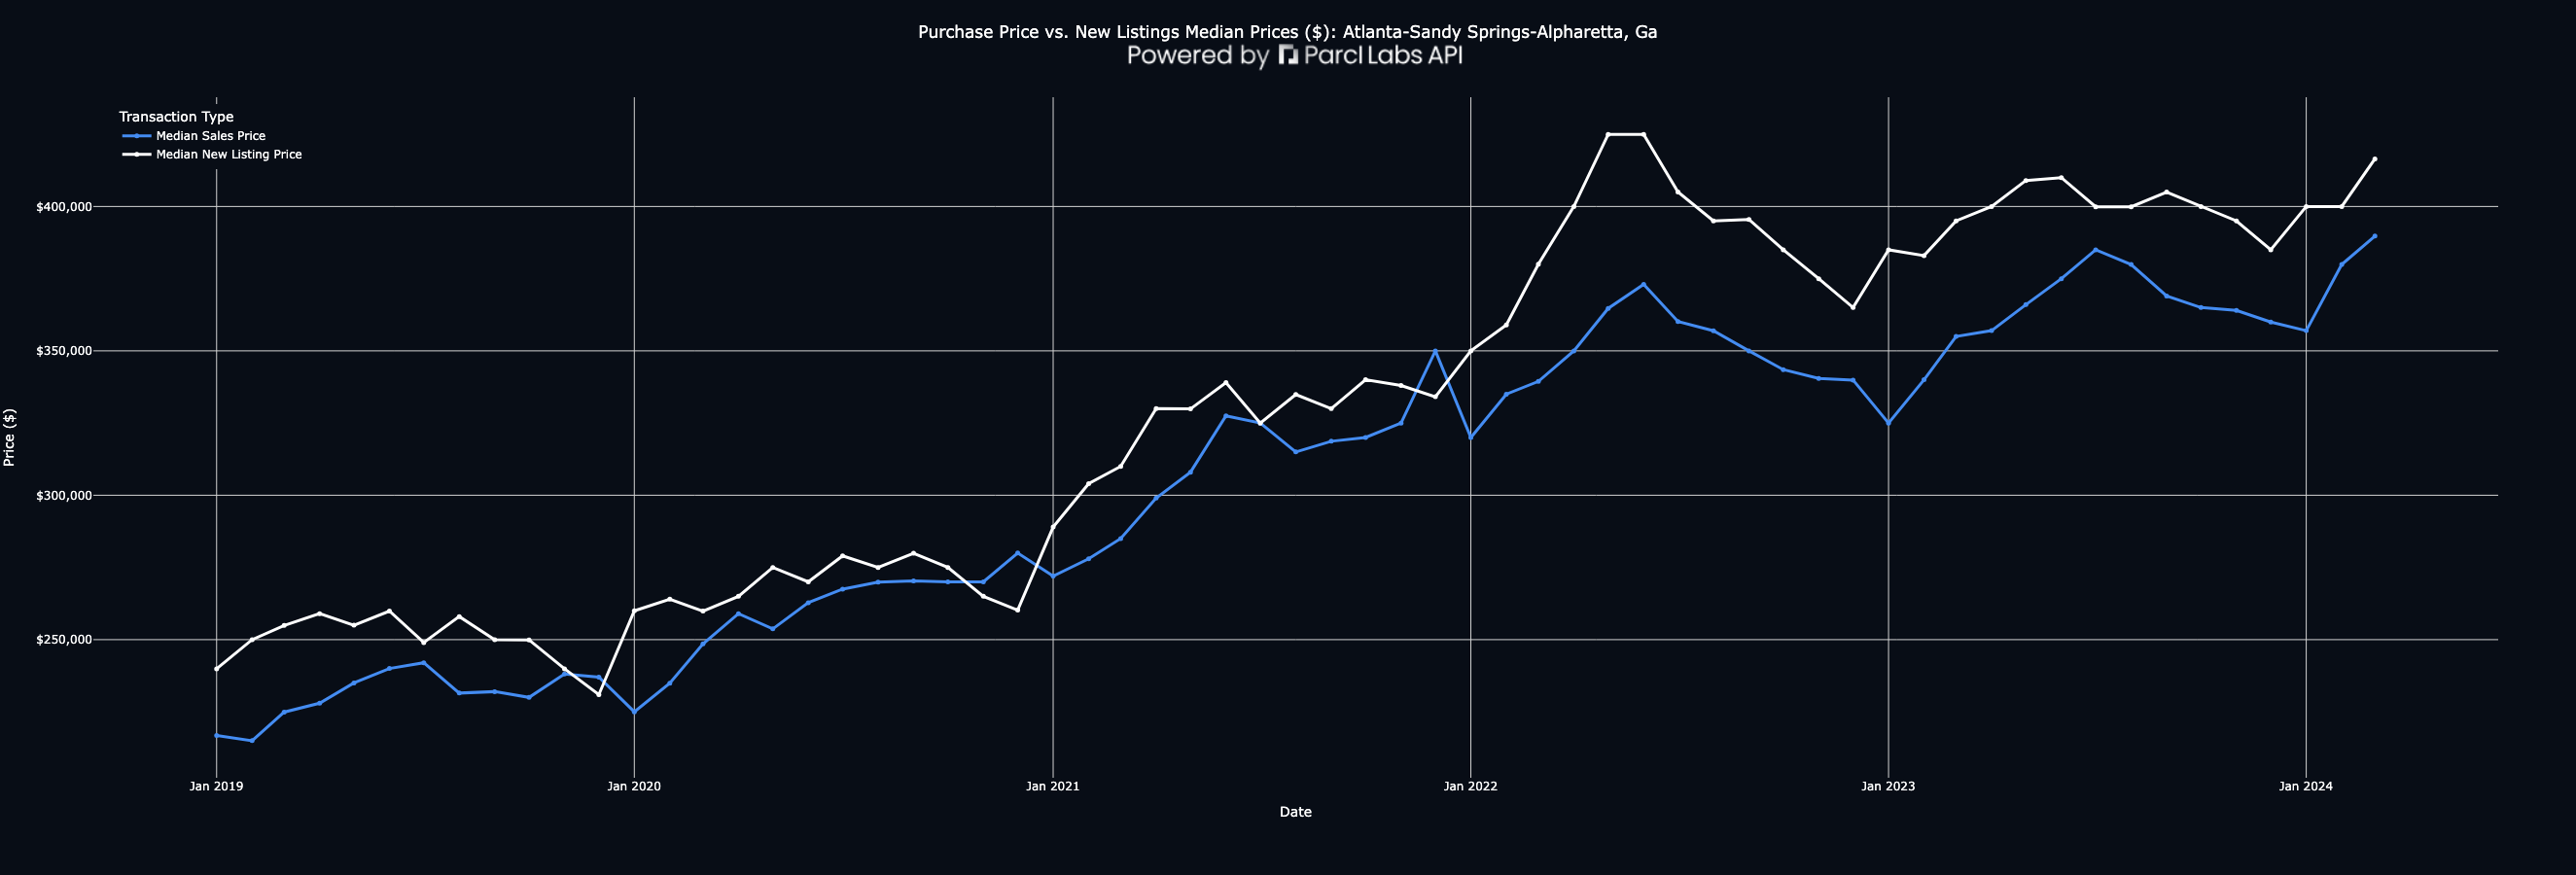

In [50]:
# Creating the line chart
fig = px.line(
    prices_long,
    x='date',
    y='Median Price ($)',
    color='Transaction Type',
    title=f'Purchase Price vs. New Listings Median Prices ($): {name}',
)

fig.add_layout_image(
    labs_logo_dict
)

fig.update_layout(
    margin=dict(b=100),
    height=IMG_HEIGHT,
    width=IMG_WIDTH,
    title=PLOT_TITLE_SETTINGS,
    xaxis_title="Date",
    yaxis_title="Price ($)",
    yaxis_tickformat='$,', 
    xaxis_tickformat='%b %Y',
    plot_bgcolor='#080D16', 
    paper_bgcolor='#080D16',
    font=dict(color='#FFFFFF'),
    showlegend=True, 
    legend=dict(
        x=0.01,
        y=0.99,
        traceorder="normal",
        xanchor='left',
        yanchor='top'
    ),
)

color_map = {
    'Median Sales Price': '#448CF2',
    'Median New Listing Price': '#FFFFFF',
}

fig.update_traces(
    line=dict(width=3),
    mode='lines+markers',
    marker=dict(size=5)
)

for trace in fig.data:
    if trace.name in color_map:
        trace.line.color = color_map[trace.name]
        trace.marker.color = color_map[trace.name]

# Adding gridlines
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')

# save figure
fig.write_image(os.path.join(output_dir, 'purchase_price_vs_new_listings_price.png'), width=IMG_WIDTH, height=IMG_HEIGHT)

# Show the plot
fig.show()

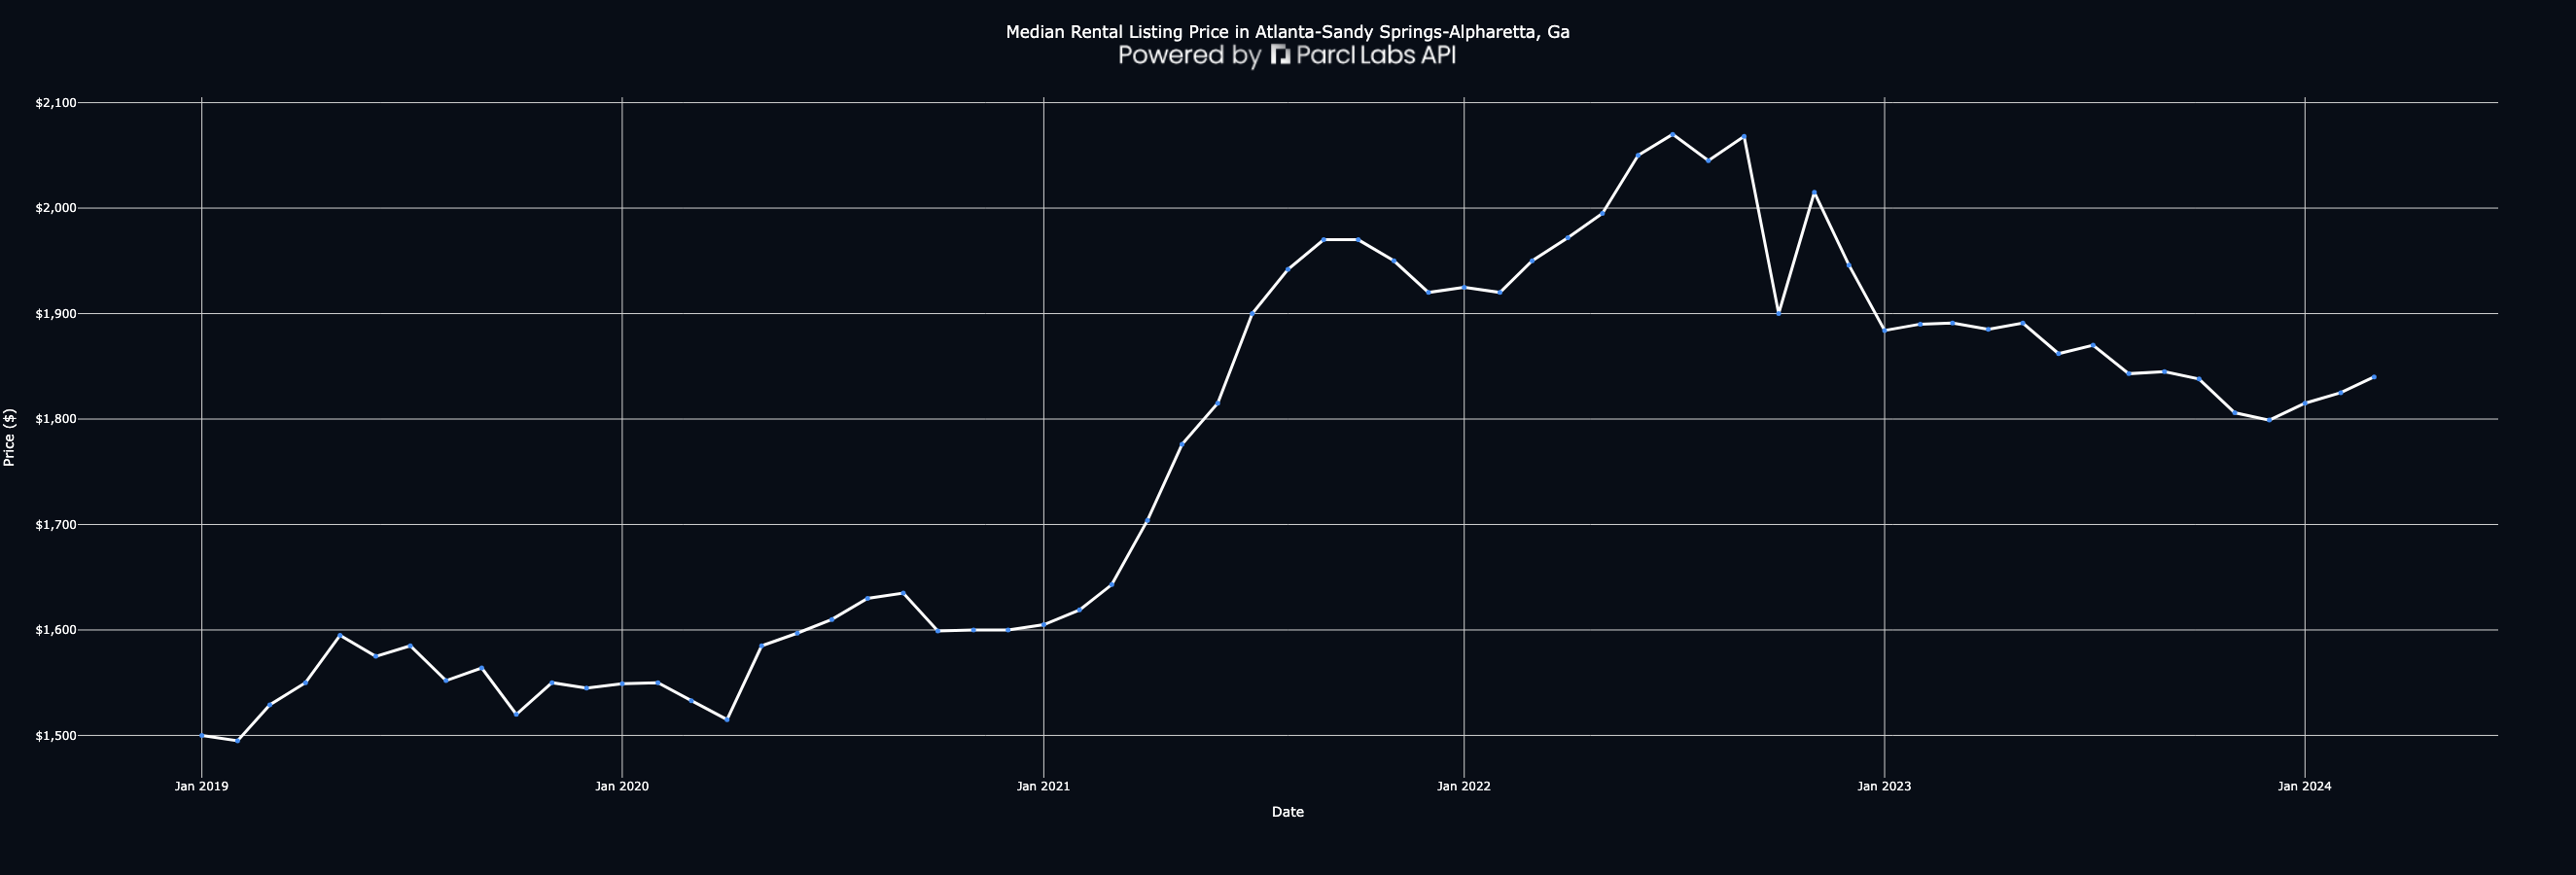

In [51]:
# we now do it for rental prices
fig = px.line(
    prices, 
    x='date', 
    y='price_median_new_rental_listings', 
    title=f'Median Rental Listing Price in {name}',  # Add city or location in title if needed
    labels={'price_median_new_rental_listings': 'Asking Rental Price ($)'},
    line_shape='linear'  # 'spline' for smooth lines, if preferred
)

# Adding layout image
fig.add_layout_image(labs_logo_dict)

fig.update_layout(
    margin=dict(b=100),
    height=IMG_HEIGHT,
    width=IMG_WIDTH,
    title=PLOT_TITLE_SETTINGS,
    xaxis_title="Date",
    yaxis_title="Price ($)",
    yaxis_tickformat='$,',
    xaxis_tickformat='%b %Y',
    plot_bgcolor='#080D16',
    paper_bgcolor='#080D16',
    font=dict(color='#FFFFFF'),
    showlegend=True,
    legend=dict(
        x=0.01,
        y=0.99,
        traceorder="normal",
        xanchor='left',
        yanchor='top'
    ),
)

fig.update_traces(
    line=dict(color='#FFFFFF', width=3),
    mode='lines+markers',
    marker=dict(color='#448CF2', size=5)
)

# Adding gridlines
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')

# save figure
fig.write_image(os.path.join(output_dir, 'median_rental_listings_price.png'), width=IMG_WIDTH, height=IMG_HEIGHT)

# Show the plot
fig.show()


<a id='listings'></a>
#### New Listings Analysis
We can also capture the change in new listings on a 7, 30, 60 and 90 day rolling basis

In [53]:
# first order of business, lets see how new listings have changed over the last year
start_date = '2023-01-01'

new_listings = client.for_sale_market_metrics_new_listings_rolling_counts.retrieve(
    parcl_id=analysis_parcl_id,
    start_date=start_date,
    as_dataframe=True,
    params={
        'limit': 300
    }
)

# we will melt the data to make it long format
new_listings_long = pd.melt(
    new_listings, 
    id_vars=['date', 'parcl_id'], 
    value_vars=['rolling_30_day', 'rolling_60_day', 'rolling_90_day'],
    value_name='Number of New Listings',
    var_name='Rolling Window (Days)'
)

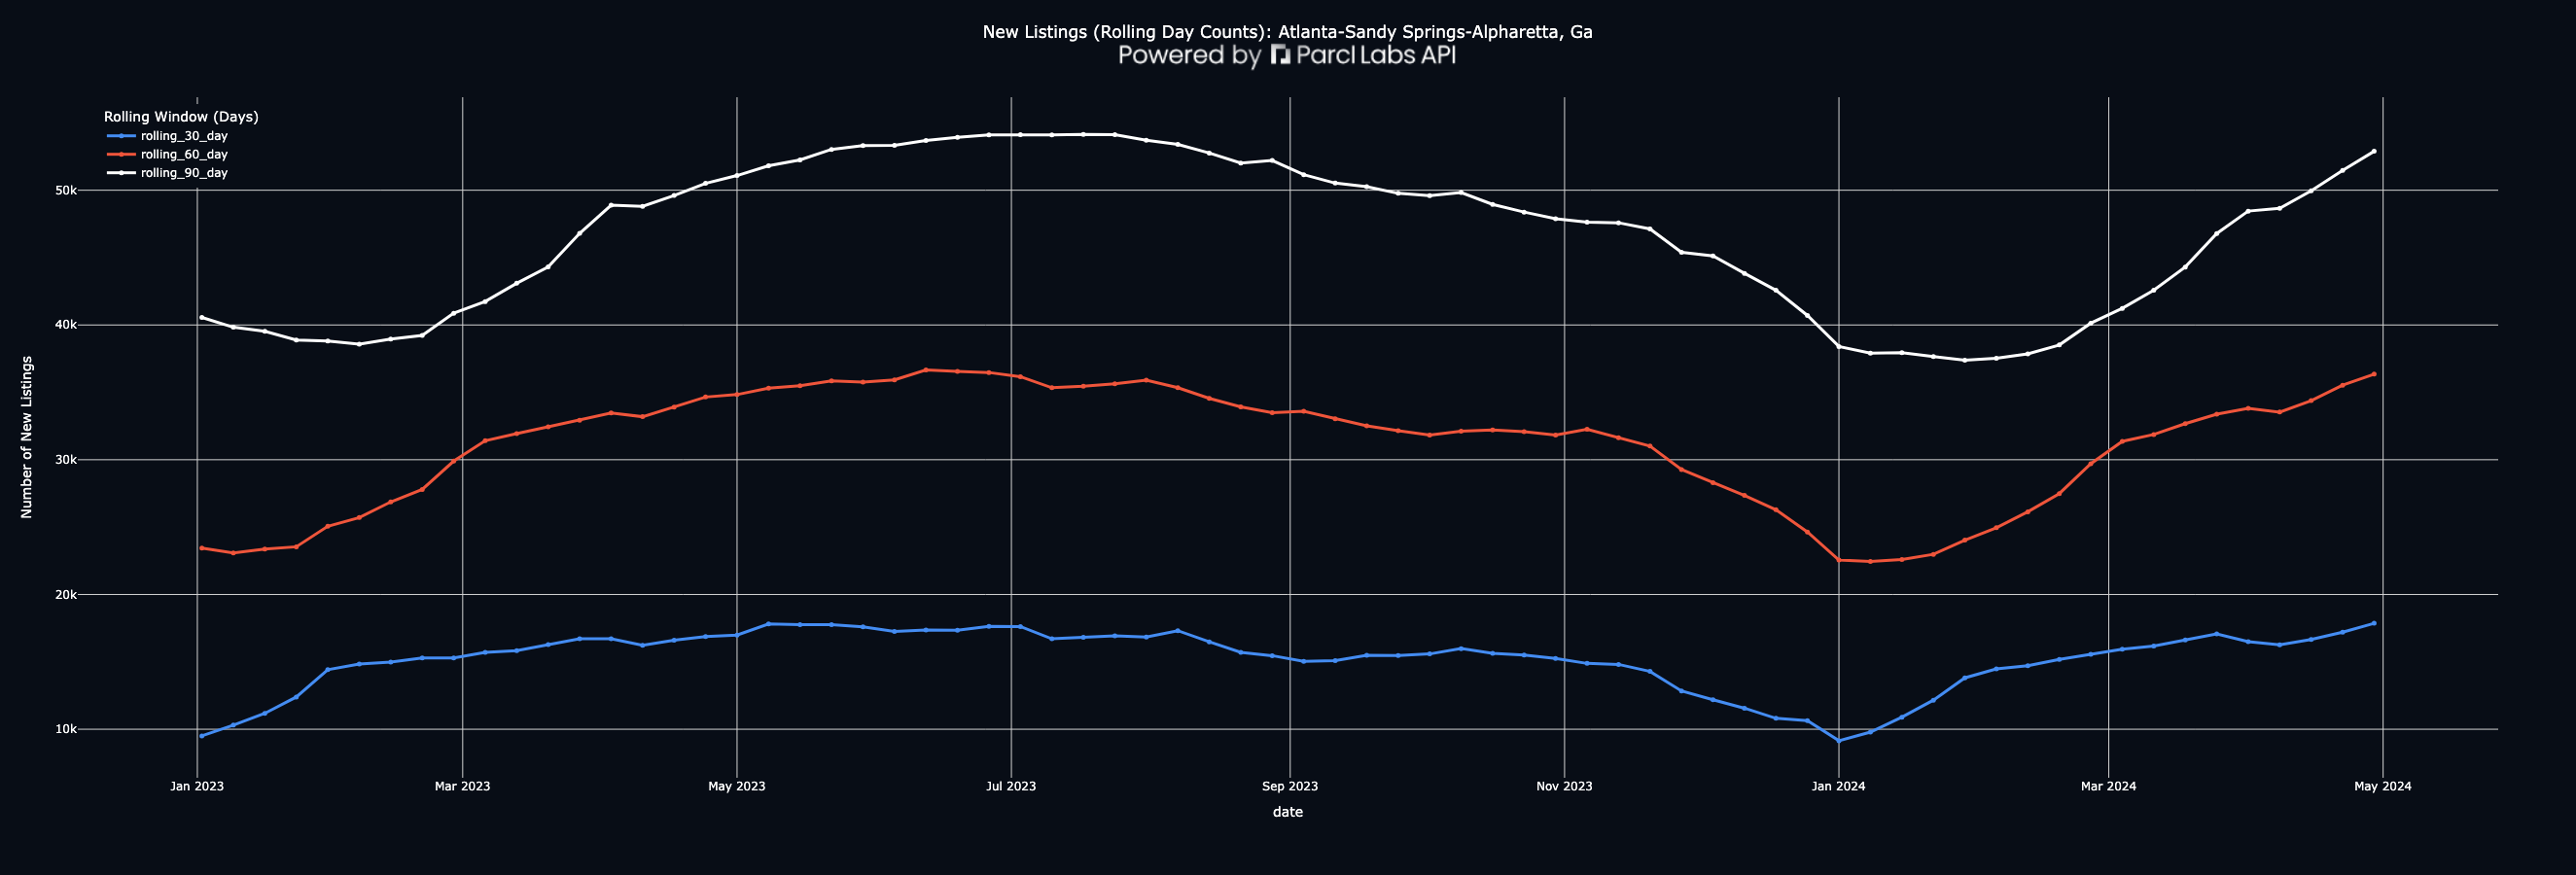

In [54]:
# Creating the line chart where we show new listings for different rolling windows
fig = px.line(
    new_listings_long,
    x='date',
    y='Number of New Listings',
    color='Rolling Window (Days)',
    title=f'New Listings (Rolling Day Counts): {name}',
    labels={'count': 'Rolling Day Count'}
)

fig.add_layout_image(
    labs_logo_dict
)

fig.update_layout(
    margin=dict(b=100),
    width=IMG_WIDTH,
    height=IMG_HEIGHT,
    legend=dict(
        x=0.01,
        y=0.99,
        traceorder="normal",
        xanchor='left',
        yanchor='top',
        title='Rolling Window (Days)'
    ),
    title=PLOT_TITLE_SETTINGS,
    plot_bgcolor='#080D16',
    paper_bgcolor='#080D16',
    font=dict(color='#FFFFFF'),
    xaxis_title='date'
)

color_map = {
    'rolling_30_day': '#448CF2',
    'rolling_90_day': '#FFFFFF',
}

fig.update_traces(
    line=dict(width=3),
    mode='lines+markers',
    marker=dict(size=5)
)

for trace in fig.data:
    if trace.name in color_map:
        trace.line.color = color_map[trace.name]
        trace.marker.color = color_map[trace.name]

# Adding gridlines
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')

# save figure
fig.write_image(os.path.join(output_dir, 'new_listings_rolling_n_periods.png'), width=IMG_WIDTH, height=IMG_HEIGHT)


# Show the plot
fig.show()

We can also determine what percent of the new listings are coming from investors that are offloading properties.

In [55]:
# of listings on the market, what percent of them are coming from investors?
investor_listings = client.investor_metrics_new_listings_for_sale_rolling_counts.retrieve(
    parcl_id=analysis_parcl_id,
    params={
        'limit': 300
    },
    as_dataframe=True
)

# we divide by 100 so plotly can handle the formatting, we also fiter out the rolling_7_day period
investor_listings['pct_for_sale_market'] = investor_listings['pct_for_sale_market']/100
investor_listings = investor_listings.loc[investor_listings['period'] != 'rolling_7_day']

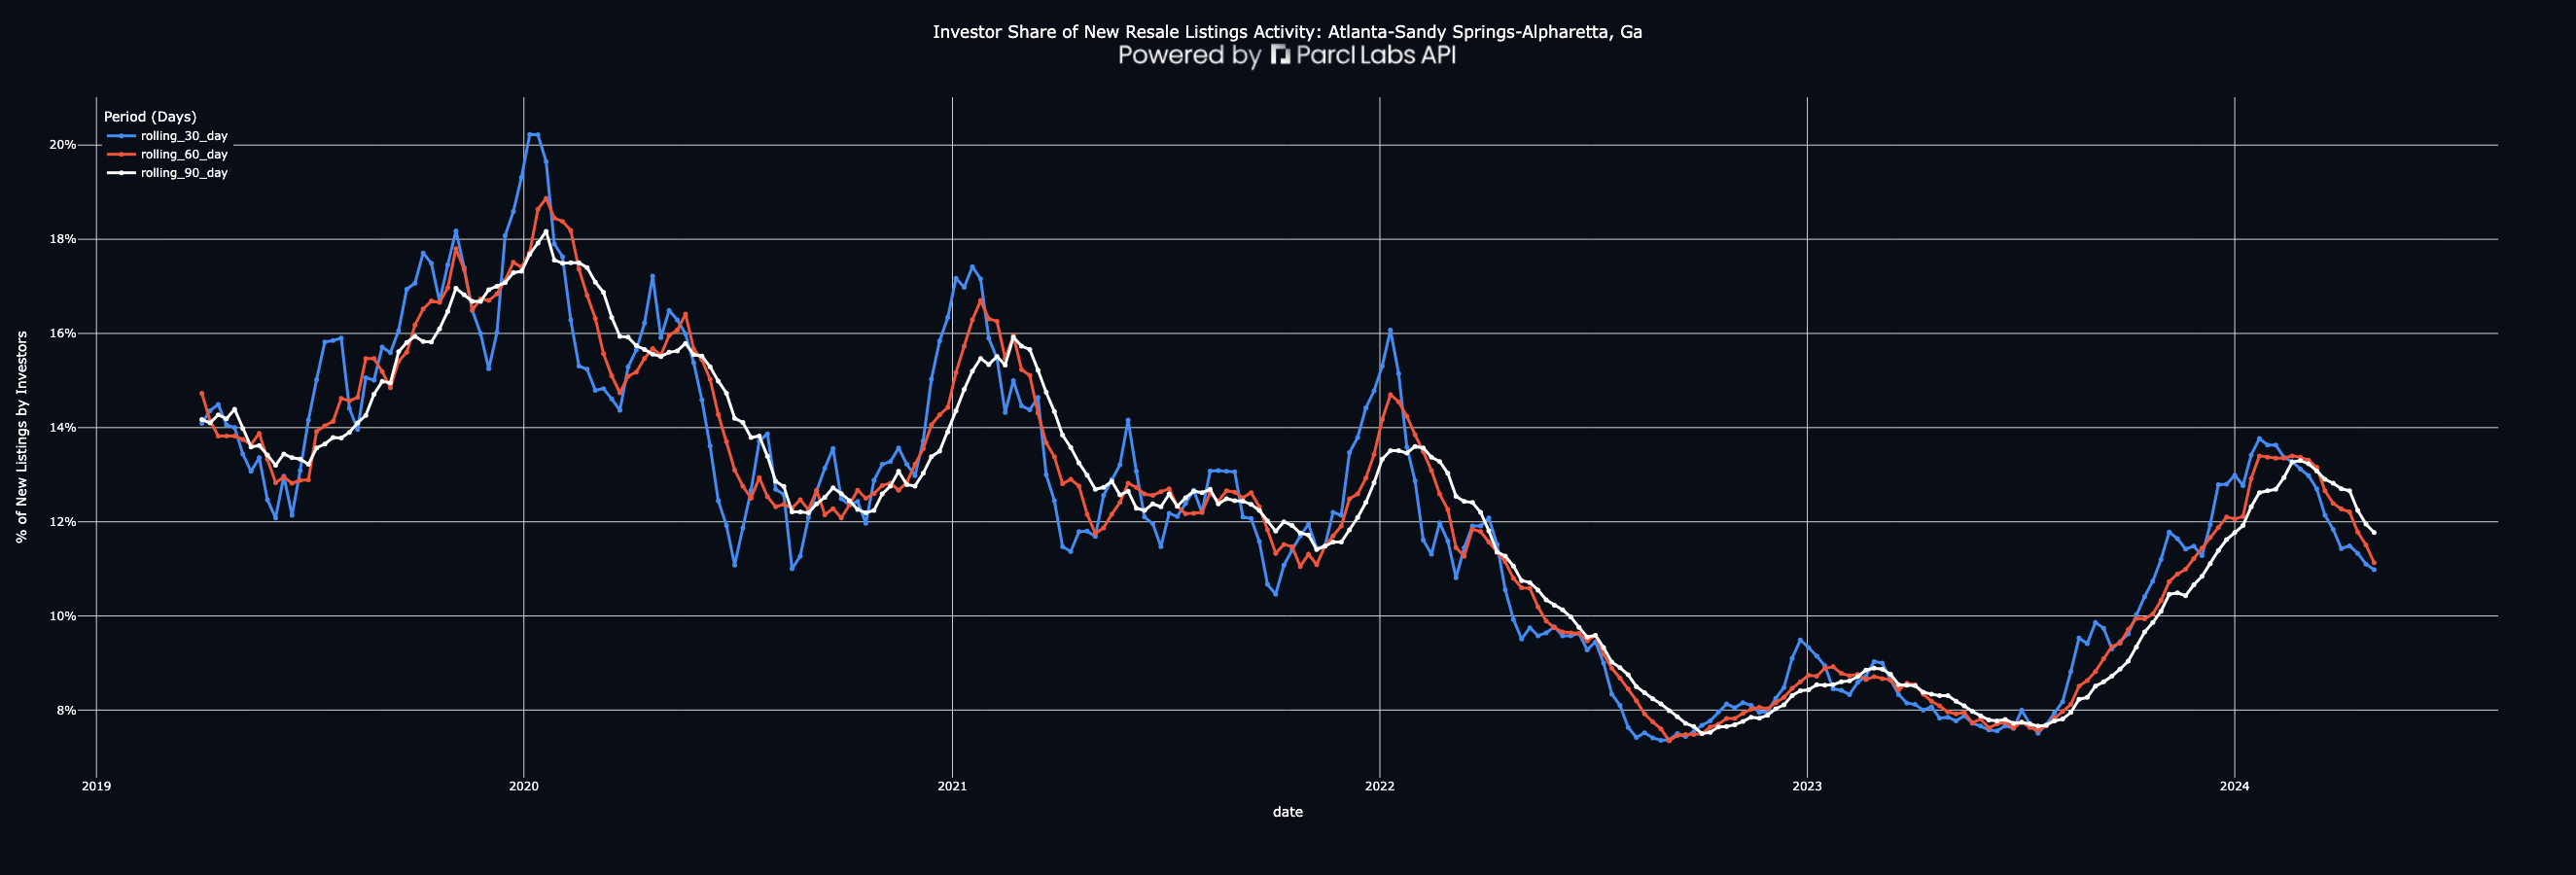

In [56]:
# Create the line chart
fig = px.line(
    investor_listings,
    x='date',
    y='pct_for_sale_market',
    color='period',  # This creates separate lines for each period
    title=f'Investor Share of New Resale Listings Activity: {name}',
    labels={'pct_for_sale_market': '% of New Listings by Investors'},
    line_shape='linear'  # 'spline' for smooth lines, if preferred
)

fig.add_layout_image(labs_logo_dict)

fig.update_layout(
    margin=dict(b=100),
    height=IMG_HEIGHT,
    width=IMG_WIDTH,
    legend=dict(
        x=0.01,
        y=0.99,
        traceorder="normal",
        xanchor='left',
        yanchor='top',
        title='Period (Days)'
    ),
    title=PLOT_TITLE_SETTINGS,
    plot_bgcolor='#080D16',
    paper_bgcolor='#080D16',
    font=dict(color='#FFFFFF'),
    xaxis_title='date' 
)

fig.update_yaxes(tickformat=".0%")

color_map = {
    'rolling_30_day': '#448CF2',
    'rolling_90_day': '#FFFFFF',
}

fig.update_traces(
    line=dict(width=3),
    mode='lines+markers',
    marker=dict(size=5)
)


for trace in fig.data:
    if trace.name in color_map:
        trace.line.color = color_map[trace.name]
        trace.marker.color = color_map[trace.name]

# Adding gridlines
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')

# save figure
fig.write_image(os.path.join(output_dir, 'investor_share_of_resale_listings_rolling_n_period.png'), width=IMG_WIDTH, height=IMG_HEIGHT)

# Show the plot
fig.show()
